In [190]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from joblib import dump, load

import tqdm
from tqdm import tqdm

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [191]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [192]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
ids = mailout_test['LNR']
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [195]:
type_lookup = pd.read_csv('./data/type_lookup.csv')
type_lookup.head()

,attr,datatype
0,KBA13_BJ_2009,numerical
1,WOHNDAUER_2008,numerical
2,D19_VERSAND_ANZ_30,numerical
3,CAMEO_DEU_2052,categorical
4,D19_VERSAND_DATUM,numerical


In [196]:
model_feat =  pd.read_csv('./data/model_feat.csv')
model_feat.head()

,model_feat
0,AGER_TYP
1,ALTER_HH
2,ANZ_HAUSHALTE_AKTIV
3,ANZ_HH_TITEL
4,ANZ_PERSONEN


In [197]:
model_feat = list(model_feat['model_feat'])
train_feat = list(mailout_train.columns)
test_feat = list(mailout_test.columns)

In [198]:
#Find model features not in customer features
model_feat_notin_train = [feat for feat in model_feat if feat not in train_feat]
model_feat_notin_test = [feat for feat in model_feat if feat not in test_feat]

len(model_feat_notin_train),len(model_feat_notin_test)

(0, 0)

# TRAIN

In [199]:
#Response DF LNR,REPONSE,CLUSTER_LABEL

train_response_df = pd.DataFrame()
train_response_df['LNR'] = mailout_train['LNR']
train_response_df['RESPONSE'] = mailout_train['RESPONSE']
train_response_df.head()

,LNR,RESPONSE
0,1763,0
1,1771,0
2,1776,0
3,1460,0
4,1783,0


In [200]:
extra_columns = ['RESPONSE']
mailout_train_extra = mailout_train[extra_columns  + ['LNR']]
mailout_train = mailout_train.drop(extra_columns, axis=1)
mailout_train = mailout_train[model_feat]
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,8.0,15.0,0.0,1.0,0.0,5.0,5D,5,2.0,...,3,3,0.0,2,6.0,9.0,3.0,3,2,4
1,1,13.0,1.0,0.0,2.0,0.0,5.0,5B,5,2.0,...,4,2,0.0,1,4.0,9.0,7.0,1,2,3
2,1,9.0,0.0,NaN,0.0,0.0,1.0,2D,2,4.0,...,7,3,0.0,1,NaN,9.0,2.0,3,1,4
3,2,6.0,4.0,0.0,2.0,0.0,2.0,2D,2,2.0,...,2,1,0.0,2,6.0,9.0,1.0,3,2,4
4,2,9.0,53.0,0.0,1.0,0.0,4.0,7B,7,6.0,...,7,1,0.0,1,6.0,9.0,3.0,3,1,3


In [201]:
mailout_train.shape

(42962, 271)

In [202]:
#FILLNA CATEGORICAL FEATS
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cat_col = ['OST_WEST_KZ','CAMEO_DEU_2015']

for cat in tqdm(cat_col):
    mailout_train[cat] = mailout_train[cat].fillna('Unknown') 
    
    temp_list = []
    temp_df = clean_feat[clean_feat['Attribute'] == cat]
    values = [str(val) for val in temp_df['Value']]
    
    for val in mailout_train[cat]:
        try:
            val = str(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append('Unknown')
        except:
            temp_list.append('Unknown')
            
    mailout_train[str(cat)] = temp_list
    mailout_train[str(cat)] = le.fit_transform(mailout_train[cat])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.96it/s]


In [204]:
age_feat = ['MIN_GEBAEUDEJAHR','GEBAEUDEJAHR']
model_feat = [feat for feat in model_feat if feat != 'GEBURTSJAHR']

In [205]:
#FILLNA NUMERICAL FEATS
num_cols = [feat for feat in model_feat if feat not in cat_col+age_feat]

for cat in tqdm(num_cols):
    temp_list = []
    temp_df = clean_feat[clean_feat['Attribute'] == str(cat)]
    values = [int(val) for val in temp_df['Value']]
    
    for val in mailout_train[cat]:
        try:
            val = int(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append(np.NaN)
        except:
            temp_list.append(np.NaN)
    mailout_train[str(cat)] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 268/268 [00:15<00:00, 18.61it/s]


In [206]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,8.0,NaN,NaN,1.0,NaN,5.0,1,5.0,2.0,...,3,3.0,0.0,2.0,6.0,9.0,3.0,3,2,4
1,1.0,13.0,1.0,NaN,2.0,NaN,5.0,1,5.0,2.0,...,4,2.0,0.0,1.0,4.0,9.0,7.0,1,2,3
2,1.0,9.0,NaN,NaN,NaN,NaN,1.0,1,2.0,4.0,...,7,3.0,0.0,1.0,NaN,9.0,2.0,3,1,4
3,2.0,6.0,4.0,NaN,2.0,NaN,2.0,1,2.0,2.0,...,2,1.0,0.0,2.0,6.0,9.0,1.0,3,2,4
4,2.0,9.0,NaN,NaN,1.0,NaN,4.0,1,7.0,6.0,...,7,1.0,0.0,1.0,6.0,9.0,3.0,3,1,3


In [207]:
mailout_train = mailout_train.fillna(mailout_train.mean())

,attr,nan_count,pct_nan,datatype
270,KBA13_ANZAHL_PKW,42962,1.0,numerical


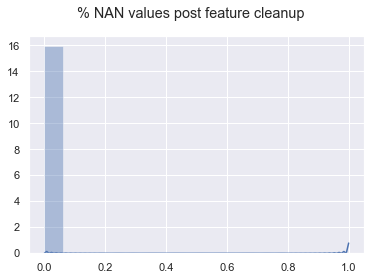

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
#figure out the nan per column
nans = mailout_train.isna().sum().sort_values()
nans_df = pd.DataFrame()
nans_df['attr'] = list(nans.index)
nans_df['nan_count'] = list(nans.values)
len_df = mailout_train.shape[0]
nans_df['pct_nan'] = [float(count)/len_df for count in nans_df['nan_count']]
nans_df = pd.merge(nans_df,type_lookup, on=['attr'])
import seaborn as sns
nums = nans_df[nans_df['datatype']=='numerical']['pct_nan']
sns.distplot([nums])
plt.suptitle('% NAN values post feature cleanup');
plt.savefig('assets/NAN_values_feat_cleanup.png')
nans_df[nans_df['pct_nan'] > 0]

In [210]:
mailout_train['KBA13_ANZAHL_PKW'] = [0]*len(mailout_train['KBA13_ANZAHL_PKW'])

In [211]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

mailout_train = scaler.fit_transform(mailout_train)
mailout_train = pd.DataFrame(mailout_train, columns=model_feat)

In [212]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.651811,-0.410526,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,0.127855,0.016142,-0.745525,...,-0.421575,1.176640,-0.067412,1.146944,0.908873,0.291966,-0.572127,0.174577,0.824885,0.736410
1,-1.218983,0.487562,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,0.127855,0.016142,-0.745525,...,0.053910,0.206405,-0.067412,-1.053221,-0.293660,0.291966,1.587486,-1.608634,0.824885,-0.200391
2,-1.218983,-0.230909,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,0.127855,-1.356478,0.389014,...,1.480366,1.176640,-0.067412,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410
3,0.651811,-0.769762,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,0.127855,-1.356478,-0.745525,...,-0.897061,-0.763830,-0.067412,1.146944,0.908873,0.291966,-1.651934,0.174577,0.824885,0.736410
4,0.651811,-0.230909,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.127855,0.931221,1.523553,...,1.480366,-0.763830,-0.067412,-1.053221,0.908873,0.291966,-0.572127,0.174577,-1.212290,-0.200391


In [213]:
from joblib import dump, load

pca = load('dump/pca.joblib')

kmeans = load('dump/kmeans_model.joblib')

In [214]:
mailout_train_pca = pca.transform(mailout_train)
mailout_train_labels = kmeans.predict(mailout_train_pca)


In [215]:
train_label_df = pd.DataFrame(list(mailout_train_labels), columns=['CLUSTER_LABEL'])
train_label_df.head()

,CLUSTER_LABEL
0,1
1,14
2,6
3,12
4,1


In [216]:
train_response_df['CLUSTER_LABEL'] = train_label_df['CLUSTER_LABEL']
train_response_df.head()

,LNR,RESPONSE,CLUSTER_LABEL
0,1763,0,1
1,1771,0,14
2,1776,0,6
3,1460,0,12
4,1783,0,1


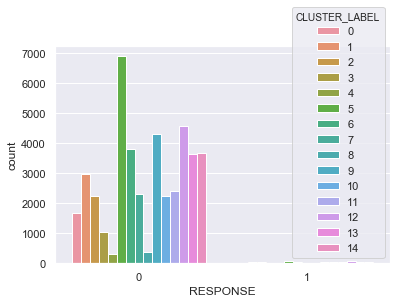

In [217]:
import seaborn as sns
sns.set(style="darkgrid")

ax = sns.countplot(x="RESPONSE", hue="CLUSTER_LABEL", data=train_response_df)

In [218]:
from imblearn.over_sampling import SMOTE

In [219]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.651811,-0.410526,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,0.127855,0.016142,-0.745525,...,-0.421575,1.176640,-0.067412,1.146944,0.908873,0.291966,-0.572127,0.174577,0.824885,0.736410
1,-1.218983,0.487562,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,0.127855,0.016142,-0.745525,...,0.053910,0.206405,-0.067412,-1.053221,-0.293660,0.291966,1.587486,-1.608634,0.824885,-0.200391
2,-1.218983,-0.230909,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,0.127855,-1.356478,0.389014,...,1.480366,1.176640,-0.067412,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410
3,0.651811,-0.769762,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,0.127855,-1.356478,-0.745525,...,-0.897061,-0.763830,-0.067412,1.146944,0.908873,0.291966,-1.651934,0.174577,0.824885,0.736410
4,0.651811,-0.230909,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.127855,0.931221,1.523553,...,1.480366,-0.763830,-0.067412,-1.053221,0.908873,0.291966,-0.572127,0.174577,-1.212290,-0.200391


In [220]:
X = mailout_train
y = train_response_df[['RESPONSE']]

In [221]:
resampler = SMOTE(random_state=777)
X_res, y_res = resampler.fit_sample(X, y.values)
print(X_res.shape, y_res.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(84860, 271) (84860,)


In [222]:
x_df = pd.DataFrame(X_res, columns=X.columns)
y_df = pd.DataFrame(y_res, columns=y.columns)

In [223]:
smote_train_df = pd.merge(x_df , y_df, left_index=True, right_index=True)

In [224]:
smote_train_df.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,0.651811,-0.410526,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,0.127855,0.016142,-0.745525,...,1.176640,-0.067412,1.146944,0.908873,0.291966,-0.572127,0.174577,0.824885,0.736410,0
1,-1.218983,0.487562,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,0.127855,0.016142,-0.745525,...,0.206405,-0.067412,-1.053221,-0.293660,0.291966,1.587486,-1.608634,0.824885,-0.200391,0
2,-1.218983,-0.230909,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,0.127855,-1.356478,0.389014,...,1.176640,-0.067412,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410,0
3,0.651811,-0.769762,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,0.127855,-1.356478,-0.745525,...,-0.763830,-0.067412,1.146944,0.908873,0.291966,-1.651934,0.174577,0.824885,0.736410,0
4,0.651811,-0.230909,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.127855,0.931221,1.523553,...,-0.763830,-0.067412,-1.053221,0.908873,0.291966,-0.572127,0.174577,-1.212290,-0.200391,0


In [225]:
smote_train_response_df = pd.DataFrame()
smote_train_response_df['RESPONSE'] = smote_train_df['RESPONSE']

In [226]:
smote_mailout_train_pca = pca.transform(x_df)
smote_mailout_train_labels = kmeans.predict(smote_mailout_train_pca)
smote_train_label_df = pd.DataFrame(list(smote_mailout_train_labels), columns=['CLUSTER_LABEL'])
smote_train_response_df['CLUSTER_LABEL'] = smote_train_label_df['CLUSTER_LABEL']
smote_train_response_df.head()

,RESPONSE,CLUSTER_LABEL
0,0,1
1,0,14
2,0,6
3,0,12
4,0,1


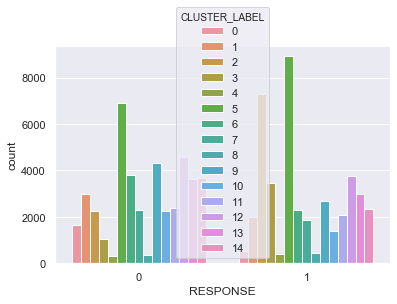

In [227]:
ax = sns.countplot(x="RESPONSE", hue="CLUSTER_LABEL", data=smote_train_response_df)

TRAIN THE MODEL

In [228]:
smote_train_df.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,0.651811,-0.410526,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,0.127855,0.016142,-0.745525,...,1.176640,-0.067412,1.146944,0.908873,0.291966,-0.572127,0.174577,0.824885,0.736410,0
1,-1.218983,0.487562,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,0.127855,0.016142,-0.745525,...,0.206405,-0.067412,-1.053221,-0.293660,0.291966,1.587486,-1.608634,0.824885,-0.200391,0
2,-1.218983,-0.230909,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,0.127855,-1.356478,0.389014,...,1.176640,-0.067412,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410,0
3,0.651811,-0.769762,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,0.127855,-1.356478,-0.745525,...,-0.763830,-0.067412,1.146944,0.908873,0.291966,-1.651934,0.174577,0.824885,0.736410,0
4,0.651811,-0.230909,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.127855,0.931221,1.523553,...,-0.763830,-0.067412,-1.053221,0.908873,0.291966,-0.572127,0.174577,-1.212290,-0.200391,0


In [262]:
#split data
X = smote_train_df[model_feat]
y = smote_train_df['RESPONSE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

In [230]:
# clf = XGBClassifier(colsample_bytree=0.75,
#                     eta=0.25,
#                     gamma=0.5,
#                     max_depth=8,
#                     min_child_weight=1,
#                     n_estimators=673,
#                     subsample=0.8,
#                     random_state = 777, 
#                     tree_method='gpu_hist')

In [231]:
# xgboost = clf.fit(X_train, y_train)
# y_pred = xgboost.predict(X_val)

# print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

In [269]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True, max_depth=100) 

param_grid = { 
    'n_estimators': [100, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [250,500,1000,1500]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

KeyboardInterrupt: 

In [271]:
#clf = RandomForestClassifier(n_estimators=175, max_depth=1000,random_state=10)
clf = RandomForestClassifier(n_estimators=700,random_state=10, max_features='sqrt')
rfc = clf.fit(X_train, y_train) 

In [272]:
y_pred = rfc.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.9417275512609004


In [273]:
#export model
# dump(xgboost, './dump/xgboost.joblib')
dump(rfc, './dump/rfc.joblib')

['./dump/rfc.joblib']

In [274]:
#import model
# xgboost = load('dump/xgboost.joblib')
rfc = load('dump/rfc.joblib')

# Test Model

In [292]:
mailout_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,12,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,12,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,6,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,12,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,11,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [293]:
model_feat = pd.read_csv('./data/model_feat.csv')
model_feat.head()

,model_feat
0,AGER_TYP
1,ALTER_HH
2,ANZ_HAUSHALTE_AKTIV
3,ANZ_HH_TITEL
4,ANZ_PERSONEN


In [294]:
model_feat = list(model_feat['model_feat'])
len(model_feat)

271

In [295]:
mailout_test = mailout_test[model_feat]
mailout_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,12,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,12,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,6,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,12,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,11,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [296]:
X_test = mailout_test

In [297]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,12,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,12,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,6,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,12,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,11,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [298]:
#FILLNA CATEGORICAL FEATS
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cat_col = ['OST_WEST_KZ','CAMEO_DEU_2015']

for cat in tqdm(cat_col):
    X_test[cat] = X_test[cat].fillna('Unknown') 
    
    temp_list = []
    temp_df = clean_feat[clean_feat['Attribute'] == cat]
    values = [str(val) for val in temp_df['Value']]
    
    for val in X_test[cat]:
        try:
            val = str(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append('Unknown')
        except:
            temp_list.append('Unknown')
            
    X_test[str(cat)] = temp_list
    X_test[str(cat)] = le.fit_transform(X_test[cat])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.40it/s]


In [299]:
#FILLNA NUMERICAL FEATS
num_cols = [feat for feat in model_feat if feat not in cat_col+age_feat]

for cat in tqdm(num_cols):
    temp_list = []
    temp_df = clean_feat[clean_feat['Attribute'] == str(cat)]
    values = [int(val) for val in temp_df['Value']]
    
    for val in X_test[cat]:
        try:
            val = int(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append(np.NaN)
        except:
            temp_list.append(np.NaN)
    X_test[str(cat)] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 268/268 [00:06<00:00, 42.62it/s]


In [300]:
X_test = X_test.fillna(X_test.mean())

,attr,nan_count,pct_nan,datatype
242,D19_BANKEN_ONLINE_DATUM,42833,1.0,numerical
243,ANZ_TITEL,42833,1.0,numerical
244,D19_BANKEN_DATUM,42833,1.0,numerical
245,ANZ_HAUSHALTE_AKTIV,42833,1.0,numerical
246,ANZ_HH_TITEL,42833,1.0,numerical
247,ANZ_PERSONEN,42833,1.0,numerical
248,KBA13_ANZAHL_PKW,42833,1.0,numerical
249,D19_BANKEN_OFFLINE_DATUM,42833,1.0,numerical
250,GFK_URLAUBERTYP,42833,1.0,numerical
251,D19_TELKO_OFFLINE_DATUM,42833,1.0,numerical


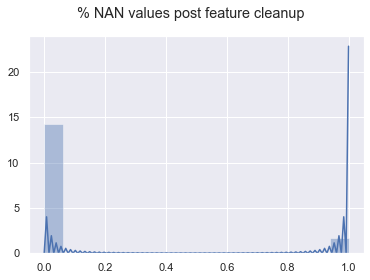

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns
#figure out the nan per column
nans = X_test.isna().sum().sort_values()
nans_df = pd.DataFrame()
nans_df['attr'] = list(nans.index)
nans_df['nan_count'] = list(nans.values)
len_df = X_test.shape[0]
nans_df['pct_nan'] = [float(count)/len_df for count in nans_df['nan_count']]
nans_df = pd.merge(nans_df,type_lookup, on=['attr'])
import seaborn as sns
nums = nans_df[nans_df['datatype']=='numerical']['pct_nan']
sns.distplot([nums])
plt.suptitle('% NAN values post feature cleanup');
plt.savefig('assets/NAN_values_feat_cleanup.png')
nans_df[nans_df['pct_nan'] > 0]

In [246]:
X_test['KBA13_ANZAHL_PKW'] = [0]*len(X_test['KBA13_ANZAHL_PKW'])

In [247]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.666667,0.333333,0.111111,0.029947,0.500000,0.045833,0.833333,0.136364,0.125,0.8,...,1.000000,1.000000,0.0,0.0,1.000000,1.0,0.375,0.4,0.0,0.375
1,0.550505,0.000000,0.203368,0.029947,0.000000,0.045833,1.000000,0.409091,0.500,0.0,...,0.833333,0.666667,0.0,0.0,1.000000,1.0,0.625,0.4,0.0,0.375
2,0.666667,0.761905,0.111111,0.029947,0.385238,0.045833,0.000000,0.681818,0.750,0.2,...,0.333333,1.000000,0.0,0.0,0.333333,1.0,0.500,0.4,1.0,0.375
3,0.550505,0.000000,0.000000,0.029947,0.385238,0.045833,0.000000,0.136364,0.125,0.6,...,0.166667,1.000000,0.0,1.0,0.748214,1.0,0.250,0.4,1.0,0.375
4,0.333333,1.000000,0.000000,0.029947,0.385238,0.045833,0.833333,0.409091,0.500,1.0,...,0.333333,1.000000,0.0,0.0,0.500000,1.0,0.875,0.6,1.0,0.375


In [248]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=model_feat)

In [249]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.666667,0.333333,0.111111,0.029947,0.500000,0.045833,0.833333,0.136364,0.125,0.8,...,1.000000,1.000000,0.0,0.0,1.000000,1.0,0.375,0.4,0.0,0.375
1,0.550505,0.000000,0.203368,0.029947,0.000000,0.045833,1.000000,0.409091,0.500,0.0,...,0.833333,0.666667,0.0,0.0,1.000000,1.0,0.625,0.4,0.0,0.375
2,0.666667,0.761905,0.111111,0.029947,0.385238,0.045833,0.000000,0.681818,0.750,0.2,...,0.333333,1.000000,0.0,0.0,0.333333,1.0,0.500,0.4,1.0,0.375
3,0.550505,0.000000,0.000000,0.029947,0.385238,0.045833,0.000000,0.136364,0.125,0.6,...,0.166667,1.000000,0.0,1.0,0.748214,1.0,0.250,0.4,1.0,0.375
4,0.333333,1.000000,0.000000,0.029947,0.385238,0.045833,0.833333,0.409091,0.500,1.0,...,0.333333,1.000000,0.0,0.0,0.500000,1.0,0.875,0.6,1.0,0.375


In [250]:
X_test.to_csv('./data/X_test.csv', index=False)

In [302]:
X_test = pd.read_csv('./data/X_test.csv')
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.666667,0.333333,0.111111,0.029947,0.500000,0.045833,0.833333,0.136364,0.125,0.8,...,1.000000,1.000000,0.0,0.0,1.000000,1.0,0.375,0.4,0.0,0.375
1,0.550505,0.000000,0.203368,0.029947,0.000000,0.045833,1.000000,0.409091,0.500,0.0,...,0.833333,0.666667,0.0,0.0,1.000000,1.0,0.625,0.4,0.0,0.375
2,0.666667,0.761905,0.111111,0.029947,0.385238,0.045833,0.000000,0.681818,0.750,0.2,...,0.333333,1.000000,0.0,0.0,0.333333,1.0,0.500,0.4,1.0,0.375
3,0.550505,0.000000,0.000000,0.029947,0.385238,0.045833,0.000000,0.136364,0.125,0.6,...,0.166667,1.000000,0.0,1.0,0.748214,1.0,0.250,0.4,1.0,0.375
4,0.333333,1.000000,0.000000,0.029947,0.385238,0.045833,0.833333,0.409091,0.500,1.0,...,0.333333,1.000000,0.0,0.0,0.500000,1.0,0.875,0.6,1.0,0.375


In [303]:
y_pred = rfc.predict_proba(X_test)

In [304]:
y_pred_target = rfc.predict(X_test)

In [305]:
y_pred_target

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [306]:
y_pred

array([[0.26428571, 0.73571429],
       [0.29      , 0.71      ],
       [0.23142857, 0.76857143],
       ...,
       [0.21857143, 0.78142857],
       [0.31285714, 0.68714286],
       [0.20142857, 0.79857143]])

In [307]:
submission_df = pd.DataFrame()
submission_df['LNR'] = ids
submission_df['PROB_0'] = [ probs[0] for probs in y_pred ]
submission_df['PROB_1'] = [ probs[1] for probs in y_pred ]
submission_df['PREDICTION'] = y_pred_target

In [308]:
submission_df.head()

,LNR,PROB_0,PROB_1,PREDICTION
0,1754,0.264286,0.735714,1
1,1770,0.290000,0.710000,1
2,1465,0.231429,0.768571,1
3,1470,0.197143,0.802857,1
4,1478,0.197143,0.802857,1


In [312]:
submission_df['PREDICTION'].value_counts()

1    42833
Name: PREDICTION, dtype: int64

In [309]:
submission_df.shape

(42833, 4)

In [310]:
submit = pd.DataFrame()
submit['LNR'] = submission_df['LNR']
submit['RESPONSE'] = submission_df['PROB_1']

In [311]:
submit.to_csv('./data/submit.csv', index=False)